# Steel Surface Fault Detection #

This notebook is used to solve the machine learning problem related to the [Northeastern University (NEU) surface defect dataset](http://archive.ics.uci.edu/ml/datasets/steel+plates+faults) and to try out different XAI libraries.<br/>


The dataset contains 1800 grayscale images of six different types of steel surface defects with 300 samples of each:
- crazing
- inclusion
- patches
- pitted surface
- rolled-in scale
- scratches

(Detailed information on how the data was collected is not given.)

The purpose is to create a classifier for these faults based on the following pre-extracted features based on the [gray-level co-occurrence matrix (GLCM)](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html):
- Contrast
- Homogeneity
- Dissimilarity
- Energy
- Asymmetry

Furthermore, each classification is explained with the help of model-agnostic post-hoc explanation methods, realized with the following libraries:
- SHAP (https://github.com/slundberg/shap)
- LIME (https://github.com/marcotcr/lime)
- Anchors (https://github.com/marcotcr/anchor)

This notebook was later utilized by collegues to conduct a user based survey exploring the impact of XAI augmentations in AI-assisted decision processes. (Results yet to be published)

<br/>

### Table of Contents: ###
* [1 Set up Environment and Dataset](#ch1)
    * [1.1 Load Libraries and Set Up Parameters](#ch1.1)
    * [1.2 Quick EDA](#ch1.2)
    * [1.3 Data Cleaning and Preparation](#ch1.3)

* [2 Tree-based Modeling](#ch2)
    * [2.1 Try Some Untuned Models](#ch2.1)
    * [2.2 Hyperparameter Tuning](#ch2.2)
    * [2.3 Model Evaluation](#ch2.3)
* [3 Explainers](#ch3)
    * [3.1 SHAP](#ch3.1)
    * [3.2 LIME](#ch3.2)
    * [3.3 Anchors](#ch3.4)
* [4 Addendum](#ch4)
    * [4.1 Decision Tree for Comparison](#ch4.1)

<br/>

Feature Extraction adapted from:
- https://software.intel.com/content/www/us/en/develop/articles/use-machine-learning-to-detect-defects-on-the-steel-surface.html
- https://github.com/rplawate/steel_plate


## 1 Set up Environment and Dataset <a class="anchor" id="ch1"></a>

### 1.1 Load Libraries and Set Up Parameters <a class="anchor" id="ch1.1"></a>

In [1]:
# random seed for reproduction
seedNum = 23

In [2]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import urllib.request
import seaborn as sns
import shap
import lime
import graphviz

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence

from alibi.explainers import AnchorTabular
from datetime import datetime
from PIL import Image

# required installs:
# pip install shap
# pip install lime
# pip install alibi
# conda install python-graphviz AND install from https://graphviz.org/download/

Set up more parameters:

In [3]:
# timer for the script processing
startTimeScript = datetime.now()

# set up n_jobs
n_jobs = 6

# set flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# set number of folds for cross validation
n_folds = 10

# set various default modeling parameters
scoring = 'accuracy'

Load dataset:

In [4]:
dataset_path = 'data/hotsteel.csv'
Xy_original = pd.read_csv(dataset_path, delimiter=" ", engine='python')

In [5]:
Xy_original.replace({"Label":{0:"crazing", 1:"inclusion", 2:"patches",
                              3:"pitted surface", 4:"rolled-in scale", 5:"scratches"}},inplace=True)

In [6]:
# check for null/NaN values
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


Split data into X and y:

In [7]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (1800, 7) X_original.shape: (1800, 6) y_original.shape: (1800,)


### 1.2 Quick EDA <a class="anchor" id="ch1.2"></a>

Check distribution of labels:

In [8]:
Xy_original.groupby('Label').size()

Label
crazing            300
inclusion          300
patches            300
pitted surface     300
rolled-in scale    300
scratches          300
dtype: int64

Show examples for each type of surface defect to get a feeling about the task:

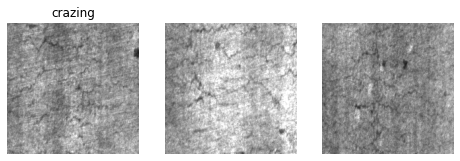

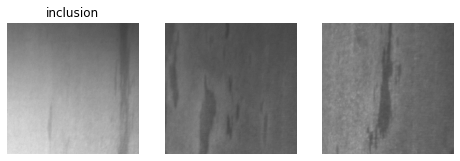

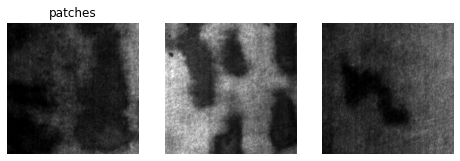

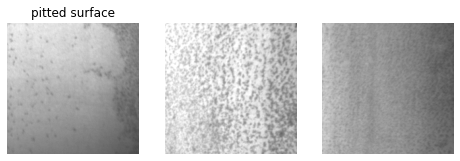

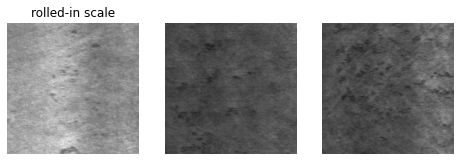

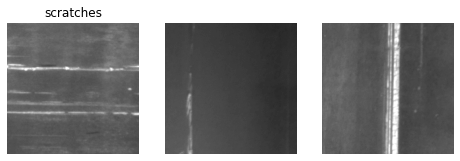

In [9]:
showExamples = True

if (showExamples):
    class_names = np.array(["crazing","inclusion","patches","pitted surface","rolled-in scale","scratches"])    
    for label in class_names:
        ilist = Xy_original.loc[Xy_original['Label'] == label].sample(3)["index"].tolist()
        limg1 = Image.open("./data/NEU images/"+ ilist[0]+".bmp")
        limg2 = Image.open("./data/NEU images/"+ ilist[1]+".bmp")
        limg3 = Image.open("./data/NEU images/"+ ilist[2]+".bmp")
        f, axarr = plt.subplots(1,3, figsize=(8,4))
        axarr[0].imshow(limg1,cmap='gray',vmin=0,vmax=255)
        axarr[0].axis('off')
        axarr[0].title.set_text(label)
        axarr[1].imshow(limg2,cmap='gray',vmin=0,vmax=255)
        axarr[1].axis('off')
        axarr[2].imshow(limg3,cmap='gray',vmin=0,vmax=255)
        axarr[2].axis('off')
        plt.show()

Take a look if low and high feature value differences are visible to the human eye:

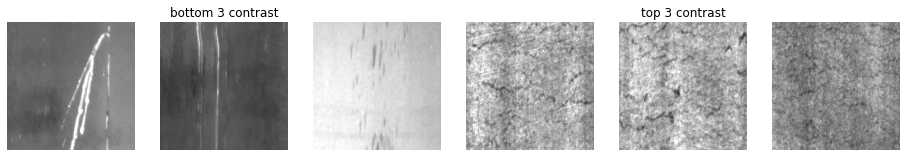

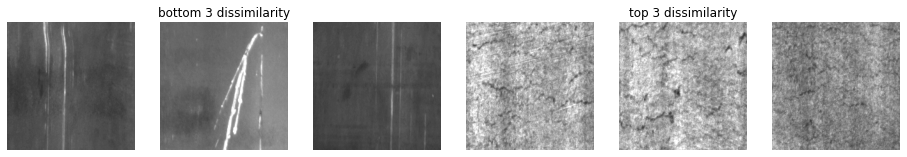

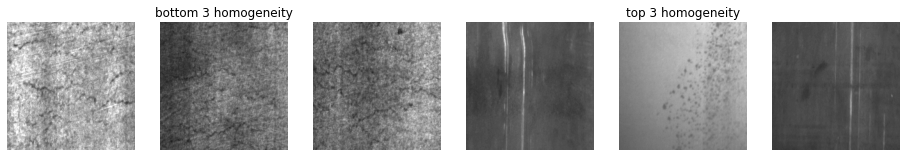

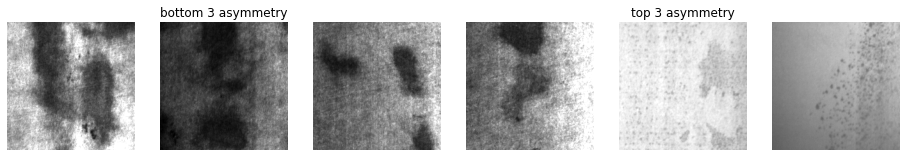

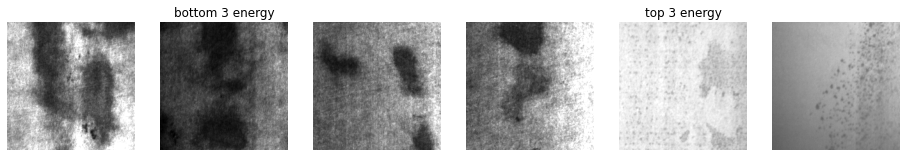

In [10]:
compareImages = True

if (compareImages):

    feature_list = X_original.iloc[:,1:totCol].columns.values.tolist()

    for feature in feature_list:
        minimum = Xy_original.nsmallest(3, feature, keep='first').index.values.tolist()
        maximum = Xy_original.nlargest(3, feature, keep='first').index.values.tolist()

        min_img1= Image.open("./data/NEU images/"+ Xy_original.iloc[minimum[0]][0]+".bmp")
        min_img2= Image.open("./data/NEU images/"+ Xy_original.iloc[minimum[1]][0]+".bmp")
        min_img3= Image.open("./data/NEU images/"+ Xy_original.iloc[minimum[2]][0]+".bmp")
        max_img1= Image.open("./data/NEU images/"+ Xy_original.iloc[maximum[0]][0]+".bmp")
        max_img2= Image.open("./data/NEU images/"+ Xy_original.iloc[maximum[1]][0]+".bmp")
        max_img3= Image.open("./data/NEU images/"+ Xy_original.iloc[maximum[2]][0]+".bmp")

        f, axarr = plt.subplots(1,6, figsize=(16,8))
        axarr[0].imshow(min_img1,cmap='gray',vmin=0,vmax=255)
        axarr[0].axis('off')

        axarr[1].imshow(min_img2,cmap='gray',vmin=0,vmax=255)
        axarr[1].axis('off')
        axarr[1].title.set_text('bottom 3 '+feature)
        
        axarr[2].imshow(min_img3,cmap='gray',vmin=0,vmax=255)
        axarr[2].axis('off')
        
        axarr[3].imshow(max_img1,cmap='gray',vmin=0,vmax=255)
        axarr[3].axis('off')
        
        axarr[4].imshow(max_img2,cmap='gray',vmin=0,vmax=255)
        axarr[4].axis('off')
        axarr[4].title.set_text('top 3 '+feature)
        
        axarr[5].imshow(max_img3,cmap='gray',vmin=0,vmax=255)
        axarr[5].axis('off')
        
        plt.show()

Images with low/high contrast and dissimilarity or asymmetry and energy look pretty close if not the same. Dissimilarity and homogeneity seem to be opposites. Thus, look for multicollinearity and strongly correlating features:

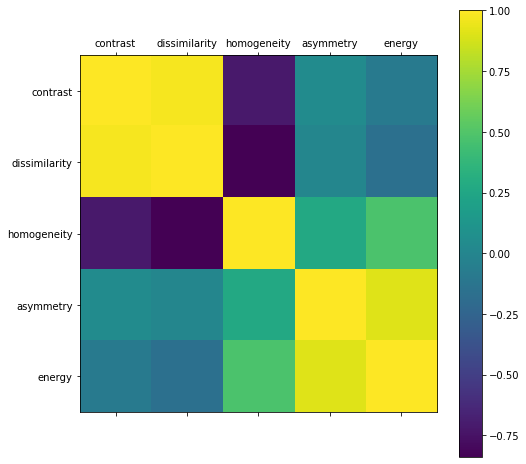

               contrast  dissimilarity  homogeneity  asymmetry    energy
contrast       1.000000       0.974012    -0.709289   0.049950 -0.079730
dissimilarity  0.974012       1.000000    -0.838070   0.002093 -0.162220
homogeneity   -0.709289      -0.838070     1.000000   0.271631  0.479672
asymmetry      0.049950       0.002093     0.271631   1.000000  0.910718
energy        -0.079730      -0.162220     0.479672   0.910718  1.000000

Mean Correlation:
contrast         0.246989
dissimilarity    0.195163
homogeneity      0.040789
asymmetry        0.446878
energy           0.429688
dtype: float64


In [11]:
f = plt.figure(figsize=(8, 8))
plt.matshow(X_original.iloc[:,1:totCol].corr(),fignum=f.number)
plt.xticks(range(len(X_original.iloc[:,1:totCol].columns)), X_original.iloc[:,1:totCol].columns)
plt.yticks(range(len(X_original.iloc[:,1:totCol].columns)), X_original.iloc[:,1:totCol].columns)
plt.colorbar()
plt.show()
print(X_original.iloc[:,1:totCol].corr())
print("\nMean Correlation:")
print(X_original.iloc[:,1:totCol].corr().mean())

There is indeed a strong linear relationship between the aforementioned feature pairs:
- contrast / dissimilarity = 0.97
- asymmetry / energy = 0.91
- dissimilarity / homogeneity = -0.8

We drop one feature of each pair with a value above 0.9 - for the sake of explainability we drop dissimilarity and energy.

In [12]:
drop_features = True

to_drop=['dissimilarity', 'energy']

if (drop_features):
    X_original = X_original.drop(X_original[to_drop], axis=1)

### 1.3 Data Cleaning and Preparation <a class="anchor" id="ch1.3"></a>

In [13]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train.shape: (1350, 4) y_train_df.shape: (1350,)
X_test_df.shape: (450, 4) y_test_df.shape: (450,)


In [14]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.iloc[:,1:totCol].to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.iloc[:,1:totCol].to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (1350, 3) y_train.shape: (1350,)
X_test.shape: (450, 3) y_test.shape: (450,)


## 2 Tree-based Modeling <a class="anchor" id="ch2"></a>

### 2.1 Try Some Untuned  Models <a class="anchor" id="ch2.1"></a>

In [15]:
# Set up Algorithms Spot-Checking Array

startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('DT', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GB', GradientBoostingClassifier(random_state=seedNum)))

In [16]:
# Generate models in turn

for name, model in train_models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=n_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - startTimeModule), '\n')
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

DT: 0.858519 (0.038696)
DecisionTreeClassifier(random_state=23)
Model training time: 0:00:00.038035 

BT: 0.873333 (0.033036)
BaggingClassifier(n_jobs=6, random_state=23)
Model training time: 0:00:01.392265 

RF: 0.882222 (0.041303)
RandomForestClassifier(n_jobs=6, random_state=23)
Model training time: 0:00:00.946859 

ET: 0.897778 (0.032084)
ExtraTreesClassifier(n_jobs=6, random_state=23)
Model training time: 0:00:01.040945 

GB: 0.885926 (0.033160)
GradientBoostingClassifier(random_state=23)
Model training time: 0:00:08.149402 

Average metrics (accuracy) from all models: 0.8795555555555555
Total training time for all models: 0:00:08.149402


We will choose RandomForestClassifier due to compatibility with SHAP TreeClassifier.

### 2.2 Hyperparameter Tuning <a class="anchor" id="ch2.2"></a>

In [17]:
# set up comparison array
tune_results = []
tune_names = []

In [18]:
# tune Random Forest

startTimeModule = datetime.now()

tune_model = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_names.append('RF')

n_estimators = [100]
criterion = ["gini","entropy"]
max_features =[None, "sqrt", 0.2, 0.3, 0.4, 0.5]

paramGrid = dict(n_estimators=n_estimators, criterion=criterion, max_features=max_features)

kfold = KFold(n_splits=n_folds)
grid = GridSearchCV(estimator=tune_model, param_grid=paramGrid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
tune_results.append(grid_result.cv_results_['mean_test_score'])
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Computing time:',(datetime.now() - startTimeModule))

Best: 0.891111 using {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}
0.885185 (0.040062) with: {'criterion': 'gini', 'max_features': None, 'n_estimators': 100}
0.882222 (0.041303) with: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.882222 (0.041303) with: {'criterion': 'gini', 'max_features': 0.2, 'n_estimators': 100}
0.882222 (0.041303) with: {'criterion': 'gini', 'max_features': 0.3, 'n_estimators': 100}
0.882222 (0.041303) with: {'criterion': 'gini', 'max_features': 0.4, 'n_estimators': 100}
0.882222 (0.041303) with: {'criterion': 'gini', 'max_features': 0.5, 'n_estimators': 100}
0.888889 (0.042164) with: {'criterion': 'entropy', 'max_features': None, 'n_estimators': 100}
0.891111 (0.045668) with: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}
0.891111 (0.045668) with: {'criterion': 'entropy', 'max_features': 0.2, 'n_estimators': 100}
0.891111 (0.045668) with: {'criterion': 'entropy', 'max_features': 0.3, 'n_estimat

### 2.3 Model Evaluation <a class="anchor" id="ch2.3"></a>

In [19]:
clf = grid_result.best_estimator_
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='sqrt', n_jobs=6,
                       random_state=23)

In [20]:
predictions = clf.predict(X_test)
print("Classifier:")
print(clf)
print()
print('Accuracy Score:', accuracy_score(y_test, predictions))
print()
print()
print("Confusion Matrix:")
print()
print(confusion_matrix(y_test, predictions))
print()
print()
print("Classification Report:")
print()
print(classification_report(y_test, predictions))

Classifier:
RandomForestClassifier(criterion='entropy', max_features='sqrt', n_jobs=6,
                       random_state=23)

Accuracy Score: 0.9022222222222223


Confusion Matrix:

[[72  0  0  1  2  0]
 [ 0 69  0  4  0  2]
 [ 6  0 65  3  1  0]
 [ 2  2  3 66  2  0]
 [ 0  0  1  0 74  0]
 [ 0  9  0  6  0 60]]


Classification Report:

                 precision    recall  f1-score   support

        crazing       0.90      0.96      0.93        75
      inclusion       0.86      0.92      0.89        75
        patches       0.94      0.87      0.90        75
 pitted surface       0.82      0.88      0.85        75
rolled-in scale       0.94      0.99      0.96        75
      scratches       0.97      0.80      0.88        75

       accuracy                           0.90       450
      macro avg       0.91      0.90      0.90       450
   weighted avg       0.91      0.90      0.90       450



## 3 Explainers <a class="anchor" id="ch3"></a>

Objects:
- clf : classifier model, previously trained and evaluated
- predictions : prediction results of clf on the test set
- class_names : array of the class names, ordered by prediction results output occurence
- feature_names : array of the feature names, in original order as in train/test data
- pred_idx : index of the prediction in the test set predictions
- class_idx : index of the class in the class_names

Labels:
- crazing
- inclusion
- patches
- pitted surface
- rolled-in scale
- scratches

In [21]:
probabilities = clf.predict_proba(X_test)
class_names = np.array(["crazing","inclusion","patches","pitted surface","rolled-in scale","scratches"])
feature_names = X_original.iloc[:,1:totCol].columns.values

Select which prediction from the test set to explain:

In [22]:
print("\nPredicted probabilities:")


Predicted probabilities:


Predicted class:  pitted surface
True class:  pitted surface

Predicted probabilities:
crazing :  0.0
inclusion :  0.0
patches :  0.28
pitted surface :  0.61
rolled-in scale :  0.11
scratches :  0.0

Image file:  PS_232


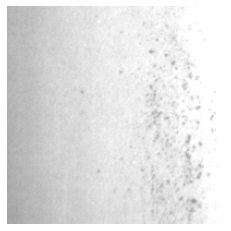

In [23]:
pred_idx = 3 # <- you can change this to select specific prediction to explain
class_idx = class_names.tolist().index(predictions[pred_idx])

print("Predicted class: ", predictions[pred_idx])
print("True class: ", y_test[pred_idx])
print("\nPredicted probabilities:")

iter=0
for label in class_names:
    print(label,": ",probabilities[pred_idx][iter])
    iter+=1

img_file = X_test_df.iloc[pred_idx][0]
print("\nImage file: ", img_file)
img_string = "./data/NEU images/"+ img_file+".bmp"
img= Image.open(img_string)
plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.axis('off')
plt.show()




### 3.1 SHAP <a class="anchor" id="ch3.1"></a>
https://github.com/slundberg/shap

In [24]:
shap.initjs()
shap_explainer = shap.TreeExplainer(clf)
shap_values = shap_explainer.shap_values(X_test)

Plot the SHAP values for the selected prediction:

In [25]:
shap.force_plot(shap_explainer.expected_value[class_idx], shap_values[class_idx][pred_idx,:], X_test[pred_idx,:], feature_names = feature_names )

Visualize the Shapley Values of the entire data set of the class of the selected prediction:

In [26]:
shap.force_plot(shap_explainer.expected_value[class_idx], shap_values[class_idx], X_test, feature_names = feature_names)

Show global importance of each feature:

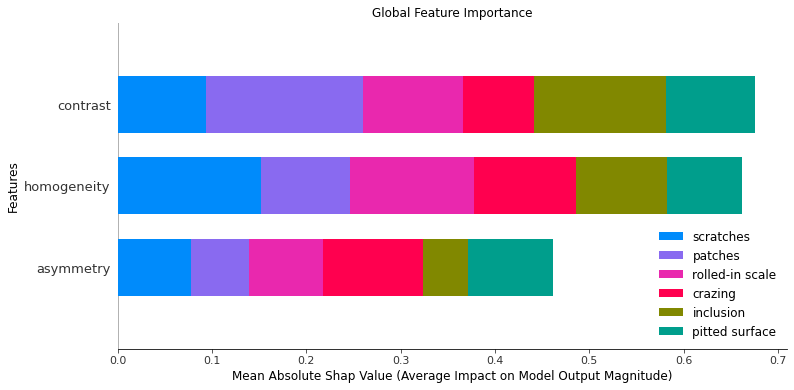

In [27]:
# global importance of each feature = mean absolute value for each feature over all the given samples and classes
# feature with highest Shap value indicates most importance on all predictions

shap.summary_plot(shap_values, X_test, show=False, class_names=class_names, feature_names = feature_names)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(12)
ax = plt.gca()
ax.set_xlabel(r'Mean Absolute Shap Value (Average Impact on Model Output Magnitude)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
plt.title("Global Feature Importance")
plt.show()

### 3.2 LIME <a class="anchor" id="ch3.2"></a>
https://github.com/marcotcr/lime

In [28]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names, discretize_continuous=True)

Visualize local explanation of the prediction:

In [29]:
exp = lime_explainer.explain_instance(X_test[pred_idx], clf.predict_proba, num_features=5, top_labels = 2)
exp.show_in_notebook(show_table=True, show_all=False)

### 3.3 Anchors <a class="anchor" id="ch3.4"></a>
https://github.com/marcotcr/anchor<br/>
https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html<br/>
(The Alibi library is used due to compatibility problems with the original source code)

In [30]:
predict_fn = lambda x: clf.predict_proba(x)
anchor_explainer = AnchorTabular(predict_fn, feature_names)
anchor_explainer.fit(X_train)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)}}
)

In [31]:
anch_exp = anchor_explainer.explain(X_test[pred_idx], threshold=0.90)

Could not find an result satisfying the 0.9 precision constraint. Now returning the best non-eligible result.


In [32]:
print('Prediction: ', class_names[anchor_explainer.predictor(X_test[pred_idx].reshape(1, -1))[0]])
print('\nAnchor:\n %s' % ('\n AND '.join(anch_exp.anchor)))
print('\nPrecision: %.2f' % anch_exp.precision)
print('Coverage: %.2f' % anch_exp.coverage)

Prediction:  pitted surface

Anchor:
 asymmetry <= 1593083.00
 AND homogeneity > 4676.52
 AND contrast <= 7824478.25

Precision: 0.58
Coverage: 0.75


For comparison the feature values of the sample:

In [33]:
count=0
for feature in feature_names:
    print(feature," = ",X_test[pred_idx][count])
    count=count+1

contrast  =  2341058.0
homogeneity  =  6354.93376214689
asymmetry  =  769010.0


## 4 Addendum <a class="anchor" id="ch4"></a>

### 4.1 Decision Tree for Comparison <a class="anchor" id="ch4.1"></a>

In [34]:
decisiontree = DecisionTreeClassifier()
param_grid_tree = {
    "max_depth": [8],
    "min_samples_leaf": [6,10,14]
}

clf_tree = GridSearchCV(decisiontree, param_grid_tree, scoring=scoring, cv=5, n_jobs=5, refit='Accuracy')
startTimeModule = datetime.now()
clf_tree.fit(X_train, y_train)

print ('Computing time:',(datetime.now() - startTimeModule))

Computing time: 0:00:00.108097


In [35]:
clf_tree.best_score_

0.8525925925925926

In [36]:
clf_tree = clf_tree.best_estimator_
clf_tree.fit(X_train, y_train)
predictions_tree = clf_tree.predict(X_test)
print("Classifier:")
print(clf_tree)
print()
print('Accuracy Score:', accuracy_score(y_test, predictions_tree))
print()
print()
print("Confusion Matrix:")
print()
print(confusion_matrix(y_test, predictions_tree))
print()
print()
print("Classification Report:")
print()
print(classification_report(y_test, predictions_tree))

Classifier:
DecisionTreeClassifier(max_depth=8, min_samples_leaf=6)

Accuracy Score: 0.8555555555555555


Confusion Matrix:

[[65  0  5  4  1  0]
 [ 0 71  0  1  0  3]
 [ 7  0 64  2  2  0]
 [ 2  4  5 58  6  0]
 [ 0  0  2  1 72  0]
 [ 0 11  6  3  0 55]]


Classification Report:

                 precision    recall  f1-score   support

        crazing       0.88      0.87      0.87        75
      inclusion       0.83      0.95      0.88        75
        patches       0.78      0.85      0.82        75
 pitted surface       0.84      0.77      0.81        75
rolled-in scale       0.89      0.96      0.92        75
      scratches       0.95      0.73      0.83        75

       accuracy                           0.86       450
      macro avg       0.86      0.86      0.85       450
   weighted avg       0.86      0.86      0.85       450



Create Output:

In [37]:
tree_classes_df = pd.DataFrame(predictions_tree)
tree_class_names = tree_classes_df[0].unique()
tree_feature_names = X_original.iloc[:,1:totCol].columns.values

In [38]:
dot_data = tree.export_graphviz(clf_tree,
                     feature_names=tree_feature_names, 
                     class_names=tree_class_names,
                     filled=False, rounded=True,
                     special_characters=True,
                     out_file=None,)

graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render("hotsteel_tree")

'hotsteel_tree.png'